**PCA Dimensionality Reduction**

In this task, I will apply the **PCA algorithm** to **reduce the dimensionality** of the data.
The goal is to reduce the number of **variables** while retaining as much **information** as possible.
First, I will **standardize** the data, then calculate the **eigenvectors** and **eigenvalues**,
which will allow me to transform the data into a **smaller number of dimensions**.

**🔍 More details and comments are available at the end of the file.**

**#0 Imports**

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# Data split and validation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Models
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score

# Transformations and data processing
from sklearn.preprocessing import PowerTransformer, StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline and column transformations
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Classification
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

**#1 Load dataset - REGRESSION**

In [2]:
bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


**#2 Data preparation**

In [3]:
bike_data_raw['dteday'] = pd.to_datetime(bike_data_raw['dteday'])

bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)

numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit']
target = 'rentals'

bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp'])/bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)
numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']

print(f'Numeric features: {numeric_features}')
print(f'Categorical features: {categorical_features}')
print(f'Target: {target}')

Numeric features: ['temp', 'difference_temp', 'hum', 'windspeed']
Categorical features: ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
Target: rentals


**#3 Data split**

In [4]:
cv = KFold(n_splits=5, shuffle=False)

In [5]:
# Split into explanatory and target variables
X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

**#4 Final model without PCA**

In [6]:
# Create final pipeline to train
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)

final_polynomial_regression_gridsearch.fit(X_train, y_train)
print("\nBest hyperparameters:", final_polynomial_regression_gridsearch.best_params_, "\n")

final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_
predictions = final_polynomial_regression_model.predict(X_test)


Best hyperparameters: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.4} 



**#5 Evaluation of final model without PCA**

In [7]:
print(f'Test R^2: {r2_score(y_test, predictions)}')
print(f'Test MAE: {mean_absolute_error(y_test, predictions)}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, predictions)}')
print(f'Test MSE: {mean_squared_error(y_test, predictions)}')
print(f'Test RMSE: {sqrt(mean_squared_error(y_test, predictions))}')

Test R^2: 0.5246818862090765
Test MAE: 348.5851935515566
Test MAPE: 0.859331973002823
Test MSE: 234195.93113132005
Test RMSE: 483.9379414050112


**#6 Final model with PCA**

In [8]:
# Final model pipeline with PCA
final_pipeline_with_pca = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('pca', PCA(random_state=42)),
                                          ('regressor', ElasticNet())])

# Define hyperparameters, including PCA
params_with_pca = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
                   'pca__n_components': [0.8, 0.85, 0.9, 0.95, 1.0, None],  # Testing different variance percentages
                   'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
                   'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

# GridSearchCV for model optimization
final_polynomial_regression_gridsearch_with_pca = GridSearchCV(final_pipeline_with_pca,
                                                               params_with_pca,
                                                               scoring='neg_mean_squared_error',
                                                               cv=cv)
# Train model with PCA
final_polynomial_regression_gridsearch_with_pca.fit(X_train, y_train)
print("\nBest hyperparameters:", final_polynomial_regression_gridsearch_with_pca.best_params_, "\n")

# Best model after GridSearchCV
final_polynomial_regression_model_with_pca = final_polynomial_regression_gridsearch_with_pca.best_estimator_
predictions_with_pca = final_polynomial_regression_model_with_pca.predict(X_test)


Best hyperparameters: {'pca__n_components': 0.9, 'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.8} 



**#7 Evaluation of final model with PCA**

In [9]:
print(f'Test R^2 (PCA): {r2_score(y_test, predictions_with_pca)}')
print(f'Test MAE (PCA): {mean_absolute_error(y_test, predictions_with_pca)}')
print(f'Test MAPE (PCA): {mean_absolute_percentage_error(y_test, predictions_with_pca)}')
print(f'Test MSE (PCA): {mean_squared_error(y_test, predictions_with_pca)}')
print(f'Test RMSE (PCA): {sqrt(mean_squared_error(y_test, predictions_with_pca))}')

Test R^2 (PCA): 0.49849208979609405
Test MAE (PCA): 363.6575548449843
Test MAPE (PCA): 0.7158967327036112
Test MSE (PCA): 247100.01279603873
Test RMSE (PCA): 497.0915537363703


**#8 Load dataset - CLASSIFICATION**

In [10]:
penguins = pd.read_csv('penguins.csv')
penguins.dropna(inplace=True)
penguins

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Species
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,0
...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,2
340,43.5,18.1,202.0,3400.0,2
341,49.6,18.2,193.0,3775.0,2
342,50.8,19.0,210.0,4100.0,2


**#9 Data preparation**

In [11]:
features = ['CulmenLength','CulmenDepth','FlipperLength','BodyMass']
target = 'Species'
X, y = penguins[features], penguins[target]

**#10 Data split**

In [12]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X[['CulmenLength', 'FlipperLength']], y, test_size=0.30, random_state=0, stratify=y)
print('Training observations: %d\nTest observations: %d' % (X_train.shape[0], X_test.shape[0]))

Training observations: 584
Test observations: 147


In [13]:
# Scaling
scaler_2var = StandardScaler()
X_train_standardized_2 = scaler_2var.fit_transform(X_train_2)
X_test_standardized_2 = scaler_2var.transform(X_test_2)

# Add PCA
pca = PCA(random_state=42)
X_train_pca_2 = pca.fit_transform(X_train_standardized_2)
X_test_pca_2 = pca.transform(X_test_standardized_2)

**#11 Function to calculate metrics**

In [14]:
metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## Metrics for the checked model ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    f1_metric = f1_score(y_checked, predictions, average='weighted')
    auc_metric = roc_auc_score(y_checked, predictions_proba, multi_class='ovr')
    new_row = pd.DataFrame({'Model': [name], 'F1_score': [f1_metric], 'AUC': [auc_metric]})
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    
    return metrics_dataframe

**#12 Classification models without PCA**

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



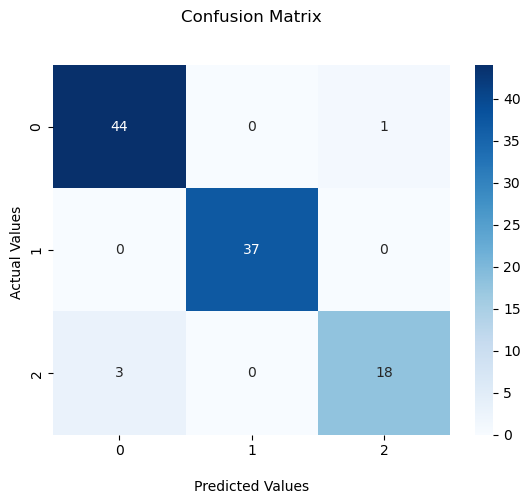

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.99357


In [15]:
# Model - Logistic Regression

model_lr = LogisticRegression()
model_lr.fit(X_train_standardized_2, y_train_2)

calculate_metrics(model_lr, 'Logistic Regression', X_test_standardized_2, y_test_2)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



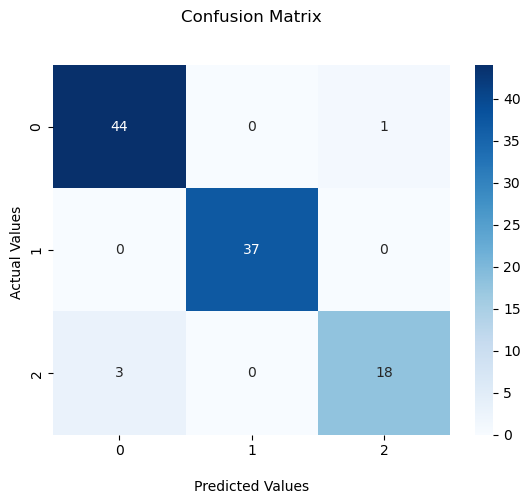

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,RandomForest,0.960616,0.985959


In [16]:
# Model - Random Forest

min_samples_leaf = max(1, int(X_train_2.shape[0]*0.001))
model_forest = RandomForestClassifier(n_estimators=1000, max_depth=3, min_samples_leaf=min_samples_leaf)
model_forest.fit(X_train_standardized_2, y_train_2)

calculate_metrics(model_forest, 'RandomForest', X_test_standardized_2, y_test_2)

**#13 Classification models with PCA**

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      1.00      1.00        37
           2       0.95      0.86      0.90        21

    accuracy                           0.96       103
   macro avg       0.96      0.94      0.95       103
weighted avg       0.96      0.96      0.96       103



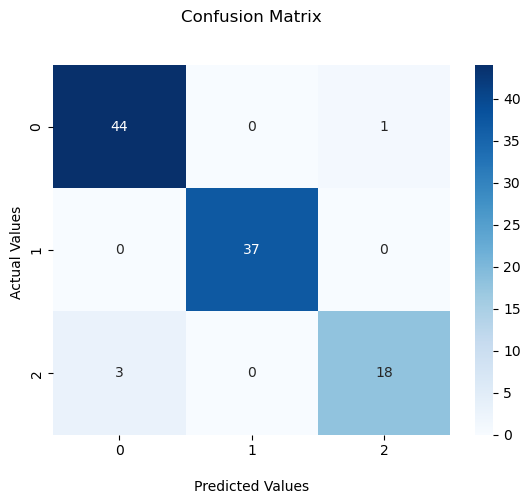

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,RandomForest,0.960616,0.985959
2,Logistic Regression with PCA,0.960616,0.993570


In [17]:
# Model - Logistic Regression

model_lr = LogisticRegression()
model_lr.fit(X_train_pca_2, y_train_2)

calculate_metrics(model_lr, 'Logistic Regression with PCA', X_test_pca_2, y_test_2)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        45
           1       0.97      0.97      0.97        37
           2       0.90      0.90      0.90        21

    accuracy                           0.96       103
   macro avg       0.95      0.95      0.95       103
weighted avg       0.96      0.96      0.96       103



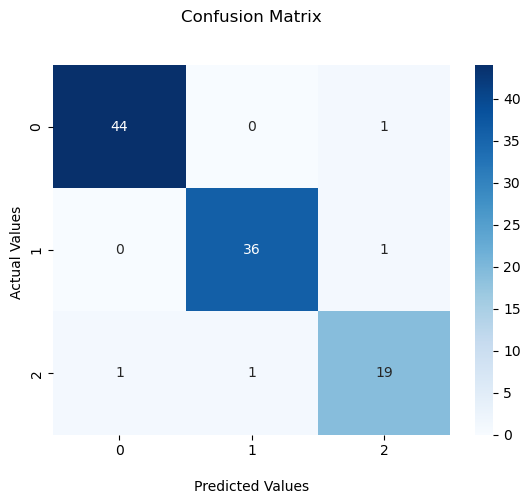

,Model,F1_score,AUC
0,Logistic Regression,0.960616,0.993570
1,RandomForest,0.960616,0.985959
2,Logistic Regression with PCA,0.960616,0.993570
3,RandomForest with PCA,0.961165,0.985336


In [18]:
# Model - Random Forest

min_samples_leaf = max(1, int(X_train_2.shape[0]*0.001))
model_forest = RandomForestClassifier(n_estimators=1000, max_depth=3, min_samples_leaf=min_samples_leaf)
model_forest.fit(X_train_pca_2, y_train_2)

calculate_metrics(model_forest, 'RandomForest with PCA', X_test_pca_2, y_test_2)

**#14 Summary**

**CLASSIFICATION**

**PCA did not impact the Logistic Regression outcome**, as the model handles a large number of features well, 
and **PCA did not improve class separation**. For RandomForest, **PCA caused a slight drop in the F1-score** 
because the model effectively selects important features by itself, and **PCA may have removed critical information**. 
AUC remained almost unchanged, indicating the **ability to distinguish classes was preserved**. 

**Conclusion**: **PCA does not always improve results** – if the features are well-selected, it may be unnecessary or even degrade the model.


**REGRESSION** 

In [19]:
# Metrics for final model without PCA
metrics_final_model = {
    "R^2": round(r2_score(y_test, predictions), 4),
    "MAE": round(mean_absolute_error(y_test, predictions), 4),
    "MAPE": round(mean_absolute_percentage_error(y_test, predictions), 4),
    "MSE": round(mean_squared_error(y_test, predictions), 4),
    "RMSE": round(sqrt(mean_squared_error(y_test, predictions)), 4)
}

# Metrics for final model with PCA
metrics_final_model_with_PCA = {
    "R^2": round(r2_score(y_test, predictions_with_pca), 4),
    "MAE": round(mean_absolute_error(y_test, predictions_with_pca), 4),
    "MAPE": round(mean_absolute_percentage_error(y_test, predictions_with_pca), 4),
    "MSE": round(mean_squared_error(y_test, predictions_with_pca), 4),
    "RMSE": round(sqrt(mean_squared_error(y_test, predictions_with_pca)), 4)
}

# Display results
print("Metric comparison:")
print(f"{'Metric':<10} {'Final model':<15} {'Final model with PCA':<15}")
print("-" * 40)
for metric in metrics_final_model.keys():
    print(f"{metric:<10} {metrics_final_model[metric]:<15} {metrics_final_model_with_PCA[metric]:<15}")

Metric comparison:
Metric     Final model     Final model with PCA
----------------------------------------
R^2        0.5247          0.4985         
MAE        348.5852        363.6576       
MAPE       0.8593          0.7159         
MSE        234195.9311     247100.0128    
RMSE       483.9379        497.0916       


**The model without PCA performed better** on most metrics like **R², MAE, MSE, and RMSE**, suggesting that without PCA, 
the model **fits the data better** and has **smaller prediction errors**. 
However, the model with PCA had a better **MAPE score**, indicating **more stable predictions** with respect to actual values. 
**Overall**, while PCA improved **stability in MAPE**, the model **without PCA was more accurate** in most cases.